# Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
input_dir = 'Data/Tutorial3'
counts_file = os.path.join(input_dir, 'Puck_200127_15.digital_expression.txt')
coor_file = os.path.join(input_dir, 'Puck_200127_15_bead_locations.csv')

In [6]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, index_col=0)
print(counts.shape, coor_df.shape)

(21220, 21724) (21724, 3)


In [7]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()

In [8]:
adata.obs_names.to_frame()

,0
TTTTTTTTTTTTTT,TTTTTTTTTTTTTT
GCTAGGATTGTAAA,GCTAGGATTGTAAA
CACAACAACGTTGG,CACAACAACGTTGG
AATGACGGCAATGC,AATGACGGCAATGC
TATTTTAGATCTCA,TATTTTAGATCTCA
...,...
GCCGCCCGTTGGCT,GCCGCCCGTTGGCT
ACAATAAGGGTCCT,ACAATAAGGGTCCT
TCTTCACTATCGCT,TCTTCACTATCGCT
AAGAATTACTAAGC,AAGAATTACTAAGC


In [9]:
coor_df.index = coor_df['barcode']
coor_df

,xcoord,ycoord,barcode
barcode,,,
TTTTTTTTTTTTTT,10.298,3031.2,TTTTTTTTTTTTTT
GCTAGGATTGTAAA,3352.500,2498.0,GCTAGGATTGTAAA
CACAACAACGTTGG,3687.400,4701.0,CACAACAACGTTGG
AATGACGGCAATGC,2706.900,2504.5,AATGACGGCAATGC
TATTTTAGATCTCA,2786.800,3984.3,TATTTTAGATCTCA
...,...,...,...
GCCGCCCGTTGGCT,3368.200,5458.2,GCCGCCCGTTGGCT
ACAATAAGGGTCCT,4522.000,2138.6,ACAATAAGGGTCCT
TCTTCACTATCGCT,3968.500,3858.4,TCTTCACTATCGCT


In [10]:
merged_df = pd.concat([adata.obs_names.to_frame(), coor_df], axis=1)
merged_df.drop(columns=[0, 'barcode'], inplace=True)
merged_df

,xcoord,ycoord
barcode,,
TTTTTTTTTTTTTT,10.298,3031.2
GCTAGGATTGTAAA,3352.500,2498.0
CACAACAACGTTGG,3687.400,4701.0
AATGACGGCAATGC,2706.900,2504.5
TATTTTAGATCTCA,2786.800,3984.3
...,...,...
GCCGCCCGTTGGCT,3368.200,5458.2
ACAATAAGGGTCCT,4522.000,2138.6
TCTTCACTATCGCT,3968.500,3858.4


In [11]:
adata.obsm["spatial"] = merged_df.to_numpy()

In [12]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [13]:
adata

AnnData object with n_obs × n_vars = 21724 × 21220
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(-289.81710000000004, 6312.7151, 173.30850000000004, 5709.8615)

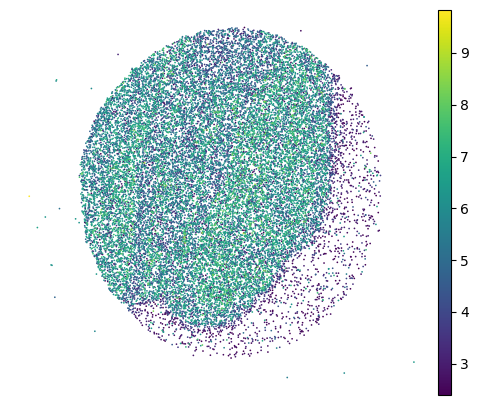

In [14]:
plt.rcParams["figure.figsize"] = (6,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=6, show=False)
plt.title('')
plt.axis('off')

In [15]:
# can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing
used_barcode = pd.read_csv('Data/Tutorial3/used_barcodes.txt', sep='\t', header=None)
used_barcode = used_barcode[0]

In [16]:
adata.obs_names

Index(['TTTTTTTTTTTTTT', 'GCTAGGATTGTAAA', 'CACAACAACGTTGG', 'AATGACGGCAATGC',
       'TATTTTAGATCTCA', 'CGCTAACGTCCTTA', 'TTCCCCGCTATCCT', 'TGATGGAAAAAGTC',
       'ATCCCAAAATAATT', 'ATCGCTATGCTTTA',
       ...
       'TCCAGTCGACGGGG', 'AACCAGTCCCCTAA', 'GGGAATAAAACCGA', 'TAACATCATTCCTA',
       'TCGACAGGTGGAGG', 'GCCGCCCGTTGGCT', 'ACAATAAGGGTCCT', 'TCTTCACTATCGCT',
       'AAGAATTACTAAGC', 'AATCCACATCTTAT'],
      dtype='object', length=21724)

In [17]:
adata = adata[used_barcode,]

(588.545, 5108.555, 847.6700000000001, 5670.73)

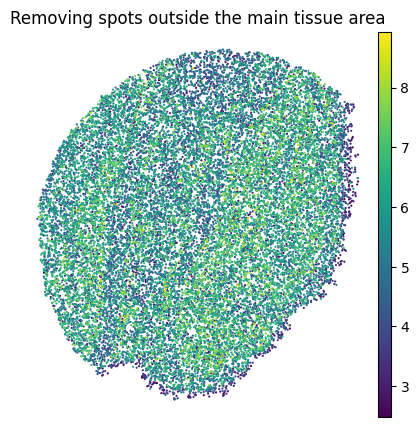

In [18]:
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=10, show=False, title='Removing spots outside the main tissue area')

plt.axis('off')

In [19]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

After flitering:  (20139, 11750)


In [20]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Constructing the spatial network

------Calculating spatial graph...
The graph contains 228300 edges, 20139 cells.
11.3362 neighbors per cell on average.


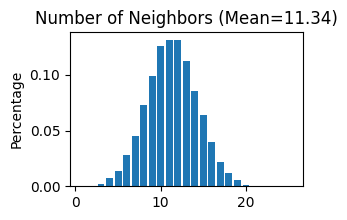

In [21]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata)

# Running STAGATE

In [22]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (20139, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2023-10-19 16:06:10.992309: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-10-19 16:06:11.011040: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2023-10-19 16:06:11.022650: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559ae8abc420 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-10-19 16:06:11.022686: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-10-19 16:06:11.024777: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-10-19 16:06:11.193781: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5599d15b5e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-19 16:06:11.193843: I tensorflow/compil

In [23]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [24]:
sc.tl.louvain(adata, resolution=0.5)

In [25]:
adata.obsm["spatial"] = adata.obsm["spatial"] * (-1)

(-5108.555, -588.545, -5670.73, -847.6700000000001)

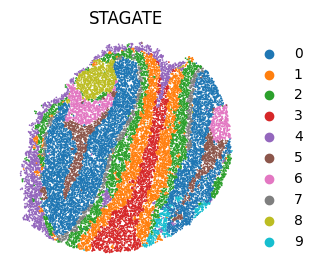

In [26]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='STAGATE')
plt.axis('off')

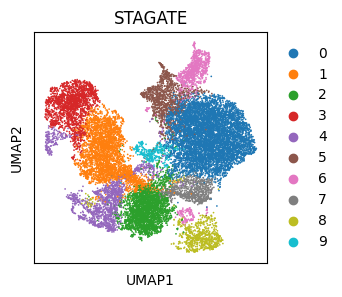

In [27]:
sc.pl.umap(adata, color='louvain', title='STAGATE')

# SCANPY results (for comparison)

In [28]:
sc.pp.pca(adata, n_comps=30)

In [29]:
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.louvain(adata, resolution=0.5)
sc.tl.umap(adata)

(-5108.555, -588.545, -5670.73, -847.6700000000001)

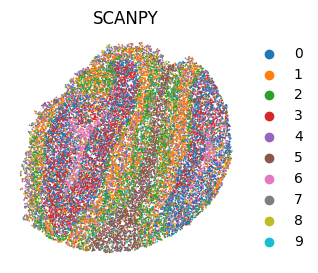

In [30]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='SCANPY')
plt.axis('off')

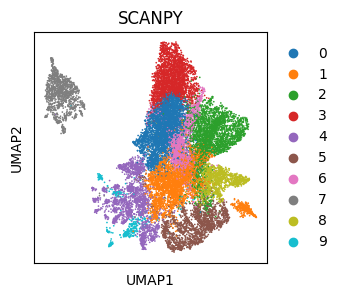

In [31]:
sc.pl.umap(adata, color='louvain', title='SCANPY')